In [1]:
import sys
sys.path.insert(0,'/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from copy import deepcopy

import time
import pickle

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor
import optimizor

# Initialize Parameters

In [ ]:
# make a para
pars = Parameters.Parameters()
pars.features = [{'Y':{'corr':False,'f':'normal'}}, # coarse-scale
                 {}]
pars.K = [3,1]
T = 10

# Simulate Data

In [ ]:
N = 3
X = np.zeros(T,dtype=int)
data = []

# define parameters
Gamma = np.array([[0.5,0.25,0.25],
                  [0.25,0.5,0.25],
                  [0.25,0.25,0.5]])
delta = np.ones(pars.K[0])/pars.K[0]

mus = [-1,0,1]
sigs = [0.1,0.1,0.1]

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(pars.K[0],p=delta)
    else:
        X[t] = np.random.choice(pars.K[0],p=Gamma[X[t-1]])

    data.append({'Y':mus[X[t]] + sigs[X[t]]*np.random.normal(),
                 'subdive_features':[]})

In [ ]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
plt.show()

# Initialize optimizor and select intial values

In [ ]:
# initialize objects
hhmm = HHMM.HHMM(pars,data)
optim1 = optimizor.optimizor(hhmm)
optim2 = optimizor.optimizor(hhmm)

# set theta and eta to true values
optim1.theta = [{'Y': {'mu': np.array([-1.0,  0.0,  1.0]),
                'sig': np.array([0.1, 0.1, 0.1]),
                'corr': np.array([0.0, 0.0, 0.0])}},
               [{}, {}, {}]]

optim1.Gamma = [np.array([[0.50, 0.25, 0.25],
                         [0.25, 0.50, 0.25],
                         [0.25, 0.25, 0.50]]),
               [np.array([[1.]]), np.array([[1.]]), np.array([[1.]])]]

optim1.eta = Gamma_2_eta(optim.Gamma)

optim1.step_size = 1e-7
optim1.param_bounds["mu"] = [-2,2]
optim1.param_bounds["sig"] = [0.01,1.0]

# set theta and eta to true values
optim2.theta = [{'Y': {'mu': np.array([-1.0,  0.0,  1.0]),
                'sig': np.array([0.1, 0.1, 0.1]),
                'corr': np.array([0.0, 0.0, 0.0])}},
               [{}, {}, {}]]

optim2.Gamma = [np.array([[0.50, 0.25, 0.25],
                         [0.25, 0.50, 0.25],
                         [0.25, 0.25, 0.50]]),
               [np.array([[1.]]), np.array([[1.]]), np.array([[1.]])]]

optim2.eta = Gamma_2_eta(optim.Gamma)

optim2.step_size = 1e-7
optim2.param_bounds["mu"] = [-2,2]
optim2.param_bounds["sig"] = [0.01,1.0]

# print values
print(optim1.theta)
print(optim1.eta)
print(optim1.param_bounds)

# Train the HMM

In [520]:
# do first optimization
num_epochs = 100
optim1.step_num = 1
optim1.train_HHMM(num_epochs,decay_ind=1)

# do second optimization
#num_epochs = 100
#optim2.step_num = 1
#optim2.train_HHMM(num_epochs,h=10,decay_ind=1)

epoch num:  1
log-likelihood:  -4.164242215717137
alpha:  1e-07

epoch num:  2
log-likelihood:  -7.493280331738518
alpha:  7.071067811865474e-08

epoch num:  3
log-likelihood:  -7.493278583572558
alpha:  5.773502691896258e-08

epoch num:  4
log-likelihood:  -7.493277156212686
alpha:  5e-08

epoch num:  5
log-likelihood:  -7.493275920091127
alpha:  4.472135954999579e-08

epoch num:  6
log-likelihood:  -7.493274814476912
alpha:  4.08248290463863e-08

epoch num:  7
log-likelihood:  -7.493273805199178
alpha:  3.779644730092272e-08

epoch num:  8
log-likelihood:  -7.493272870794098
alpha:  3.535533905932737e-08

epoch num:  9
log-likelihood:  -7.493271996742117
alpha:  3.3333333333333334e-08

epoch num:  10
log-likelihood:  -7.49327117268148
alpha:  3.162277660168379e-08

epoch num:  11
log-likelihood:  -7.493270390912033
alpha:  3.015113445777636e-08

epoch num:  12
log-likelihood:  -7.493269645526934
alpha:  2.886751345948129e-08

epoch num:  13
log-likelihood:  -7.4932689318776085
alpha:

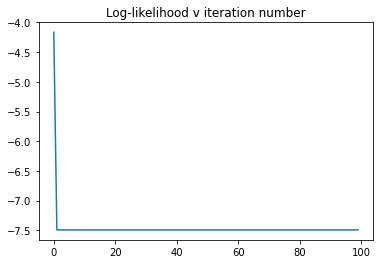

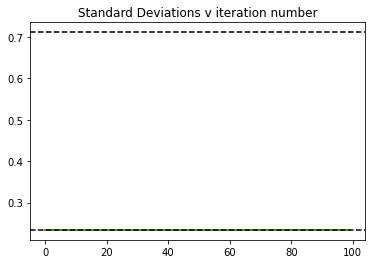

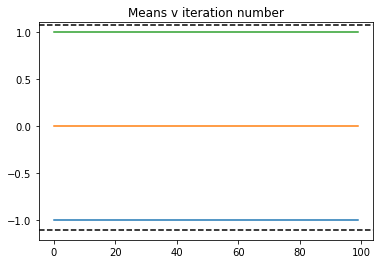

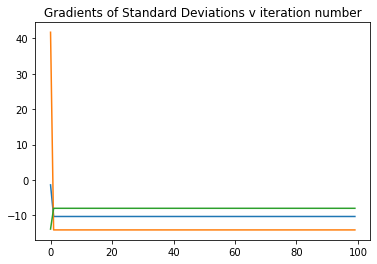

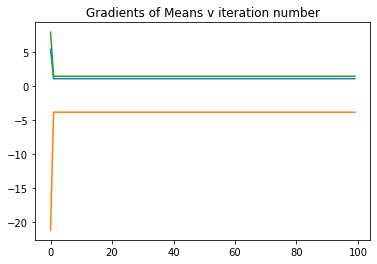

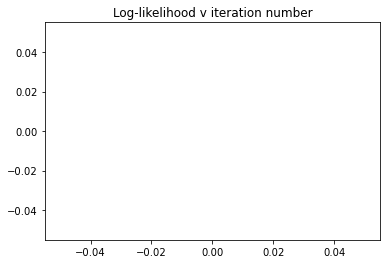

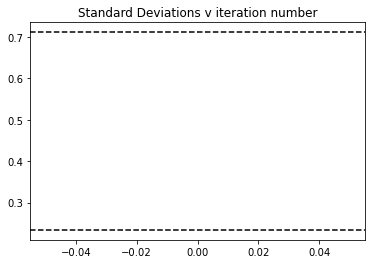

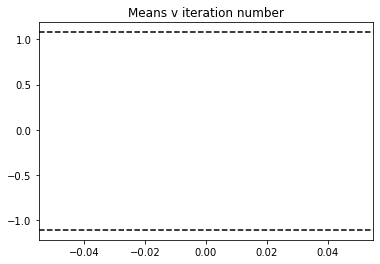

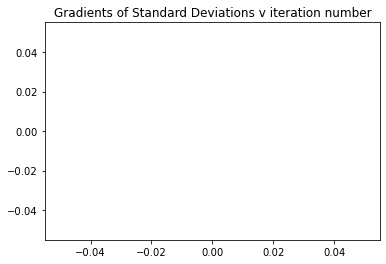

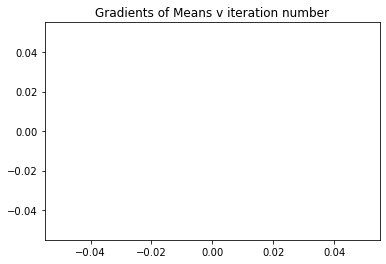

In [521]:
def plot_results(optim):
    plt.plot(optim.log_like_trace)
    plt.title("Log-likelihood v iteration number")
    plt.show()

    plt.plot([optim.theta_trace[i][0]['Y']['sig'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['sig'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['sig'][2] for i in range(len(optim.theta_trace))])
    plt.axhline(optim.param_bounds['Y']['sig'][0], c = 'k', linestyle = "--")
    plt.axhline(optim.param_bounds['Y']['sig'][1], c = 'k', linestyle = "--")
    plt.title("Standard Deviations v iteration number")
    plt.show()

    plt.plot([optim.theta_trace[i][0]['Y']['mu'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['mu'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['mu'][2] for i in range(len(optim.theta_trace))])
    plt.title("Means v iteration number")
    plt.axhline(optim.param_bounds['Y']['mu'][0], c = 'k', linestyle = "--")
    plt.axhline(optim.param_bounds['Y']['mu'][1], c = 'k', linestyle = "--")
    plt.show()

    plt.plot([optim.grad_theta_trace[i][0]['Y']['sig'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['sig'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['sig'][2] for i in range(len(optim.theta_trace))])
    plt.title("Gradients of Standard Deviations v iteration number")
    plt.show()

    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][2] for i in range(len(optim.theta_trace))])
    plt.title("Gradients of Means v iteration number")
    plt.show()
    
plot_results(optim1)
plot_results(optim2)

In [516]:
optim1.theta

[{'Y': {'mu': array([-9.99761273e-01, -8.83978836e-04,  1.00032718e+00]),
   'sig': array([0.23416417, 0.23416417, 0.23416417]),
   'corr': array([0., 0., 0.])}},
 [{}, {}, {}]]

# Make sure that the likelihoods agree

-1864.4214856148417



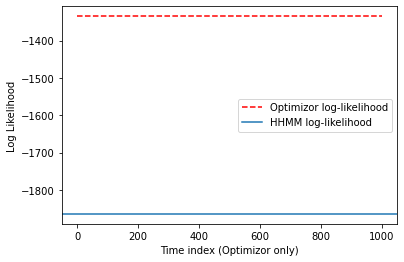

In [468]:
# using hhmm
print(hhmm.likelihood(data))
print("")
# do a forward pass and backwards pass
optim.fwd_pass(data)
optim.bwd_pass(data)

# print likelihood of evaluated at each time point
lls = [optim.log_likelihood(t) for t in range(optim.T)]
plt.plot(lls,"r--")
plt.axhline(hhmm.likelihood(data))
plt.legend(["Optimizor log-likelihood","HHMM log-likelihood"])
plt.xlabel("Time index (Optimizor only)")
plt.ylabel("Log Likelihood")
plt.show()

# Test that the gradients wrt $\theta$ agree

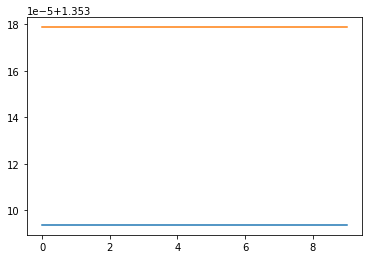

In [22]:
# test gradient of mu_Y for state 0 using my hand-code (this is mu2)
optim.fwd_pass(data)
optim.bwd_pass(data)

autograds = np.zeros(optim.T)
finite_diffs = np.zeros(optim.T)

for t in range(optim.T):

    optim.grad_log_likelihood(t)
    autograds[t] = optim.d_log_like_d_theta[t][0]["Y"]["mu"][2]

    # test finte differences - optim
    eps = 0.0001
    
    # record current likelihood
    y1 = np.copy(optim.log_likelihood(t))
    
    # adjust parameters and record result
    optim.theta[0]['Y']['mu'][2] += eps
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    y2 = np.copy(optim.log_likelihood(t))

    # record the finite difference
    finite_diffs[t] = (y2-y1)/eps

    # change the parameters back
    optim.theta[0]['Y']['mu'][2] += -eps
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    
plt.plot(autograds)
plt.plot(finite_diffs)

# Test that the gradients wrt $\eta$ agree

[-0.08564983 -0.08564983 -0.08564983 -0.08564983 -0.08564983 -0.08564983
 -0.08564983 -0.08564983 -0.08564983 -0.08564983]
[-0.08565361 -0.08565361 -0.08565361 -0.08565361 -0.08565361 -0.08565361
 -0.08565361 -0.08565361 -0.08565361 -0.08565361]


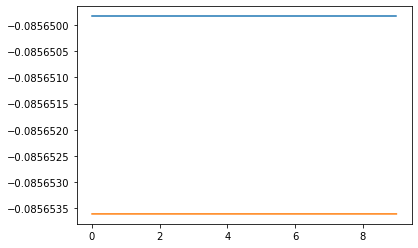

In [23]:
# test gradient of mu_Y for state 0 using my hand-code (this is mu2)
optim.fwd_pass(data)
optim.bwd_pass(data)

autograds = np.zeros(optim.T)
finite_diffs = np.zeros(optim.T)

for t in range(optim.T):

    optim.grad_log_likelihood(t)
    autograds[t] = optim.d_log_like_d_eta[t][0,1]

    # test finte differences - optim
    eps = 0.0001
    
    # record current likelihood
    y1 = np.copy(optim.log_likelihood(t))
    
    # adjust parameters and record result
    optim.eta[0][0,1] += eps
    optim.Gamma = eta_2_Gamma(optim.eta)
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    y2 = np.copy(optim.log_likelihood(t))

    # record the finite difference
    finite_diffs[t] = (y2-y1)/eps

    # change the parameters back
    optim.eta[0][0,1] += -eps
    optim.Gamma = eta_2_Gamma(optim.eta)
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    
print(autograds)
print(finite_diffs)
plt.plot(autograds)
plt.plot(finite_diffs)